In [4]:
import os

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Data
There are 8850 __events__ in the training data. Each event creates over 10k particles summing over 100k detector hits. That means each particle passes through an average of 10 silicon plates.
* __Hits__ are given as x, y, z positions and the detector groups they interacted with: volume, layer, module in increasing granularity (volume big, module small). 
* For each hit, we're also also given the __cells__ position and charge that did the detecting. These are the smallest unit of detector group, even finer than module. 
* For each event we're also given __particle__ information x, y, z momentums, and charge, and number of detectors hit from that particle.  
* Finally, we're given __truth__, telling us for certain which hits belong to which particles. Maybe this is kind of like our "y", and the other features are kind of like our "X".

This is all explained in more detail below, later.

I'll first go through some data visualization to get a sense of what's up, then eventually make my may into some physics. It's this physics that holds the key to any real modelling.

In [5]:
event_id = "000001000"

__hits__  
The hits file contains the following values for each hit/entry:  
* __hit_id__: numerical identifier of the hit inside the event.
* __x, y, z__: measured x, y, z position (in millimeter) of the hit in global coordinates.
* __volume_id__: numerical identifier of the detector group.
* __layer_id__: numerical identifier of the detector layer inside the group.
* __module_id__: numerical identifier of the detector module inside the layer.  

The volume/layer/module id could in principle be deduced from x, y, z. They are given here to simplify detector-specific data handling.

In [6]:
hits = pd.read_csv(f"data/event{event_id}-hits.csv", header=0)
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.4099,-7.163700,-1502.5,7,2,1
1,2,-55.3361,0.635342,-1502.5,7,2,1
2,3,-83.8305,-1.143010,-1502.5,7,2,1
3,4,-96.1091,-8.241030,-1502.5,7,2,1
4,5,-62.6736,-9.371200,-1502.5,7,2,1


__cells__  
The cells file contains the constituent active detector cells that comprise each hit. The cells can be used to refine the hit to track association. A cell is the smallest granularity inside each detector module, much like a pixel on a screen, except that depending on the volume_id a cell can be a square or a long rectangle. It is identified by two channel identifiers that are unique within each detector module and encode the position, much like column/row numbers of a matrix. A cell can provide signal information that the detector module has recorded in addition to the position. Depending on the detector type only one of the channel identifiers is valid, e.g. for the strip detectors, and the value might have different resolution.  
* __hit_id__: numerical identifier of the hit as defined in the hits file.
* __ch0, ch1__: channel identifier/coordinates unique within one module.
* __value__: signal value information, e.g. how much charge a particle has deposited.

In [7]:
cells = pd.read_csv(f"data/event{event_id}-cells.csv", header=0)
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


__particles__  
The particles files contains the following values for each particle/entry:  
* __particle_id__: numerical identifier of the particle inside the event.
* __vx, vy, vz__: initial position or vertex (in millimeters) in global coordinates.
* __px, py, pz__: initial momentum (in GeV/c) along each global axis.
* __q__: particle charge (as multiple of the absolute electron charge).
* __nhits__: number of hits generated by this particle.

In [8]:
particles = pd.read_csv(f"data/event{event_id}-particles.csv", header=0)
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824900,1,3


__truth__  
The truth file contains the mapping between hits and generating particles and the true particle state at each measured hit. Each entry maps one hit to one particle.  
* __hit_id__: numerical identifier of the hit as defined in the hits file.
* __particle_id__: numerical identifier of the generating particle as defined in the particles file. A value of 0 means that the hit did not originate from a reconstructible particle, but e.g. from detector noise.
* __tx, ty, tz__ true intersection point in global coordinates (in millimeters) between the particle trajectory and the sensitive surface.
* __tpx, tpy, tpz__ true particle momentum (in GeV/c) in the global coordinate system at the intersection point. The corresponding vector is tangent to the particle trajectory at the intersection point.
* __weight__ per-hit weight used for the scoring metric; total sum of weights within one event equals to one.

In [9]:
truth = pd.read_csv(f"data/event{event_id}-truth.csv", header=0)
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.4116,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.3385,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.8280,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.1229,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.6594,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


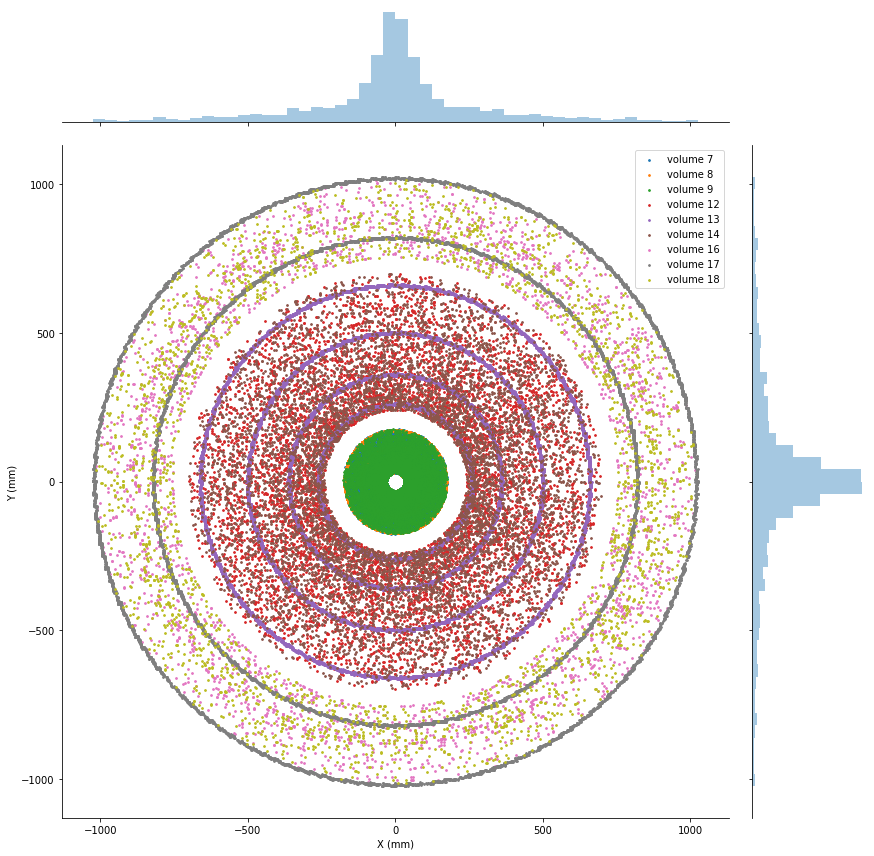

In [10]:
g = sns.jointplot(hits.x, hits.y,  s=1, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

That solid core in the middle is probably more concentric detectors. Let's zoom in and find out.

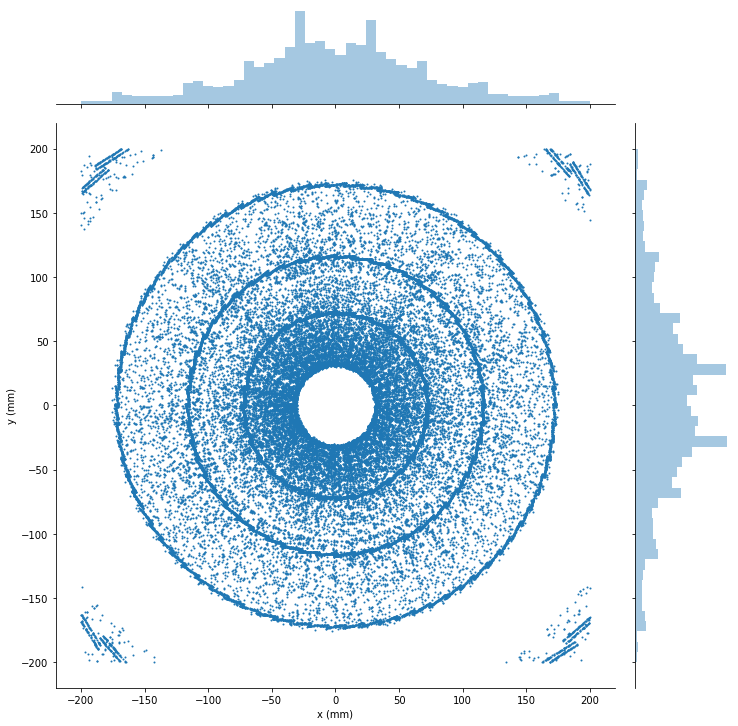

In [11]:
radialview = sns.jointplot( *(hits[(hits.x.abs()<200) & (hits.y.abs()<200)].loc[:, ["x", "y"]].values.T), height=10, s=1)
radialview.set_axis_labels('x (mm)', 'y (mm)')
plt.show()

That scattering we see in between the rings are just events from the vertical detectors. Below shows these caps removed, and again shows the concentric nature of the inner detector.

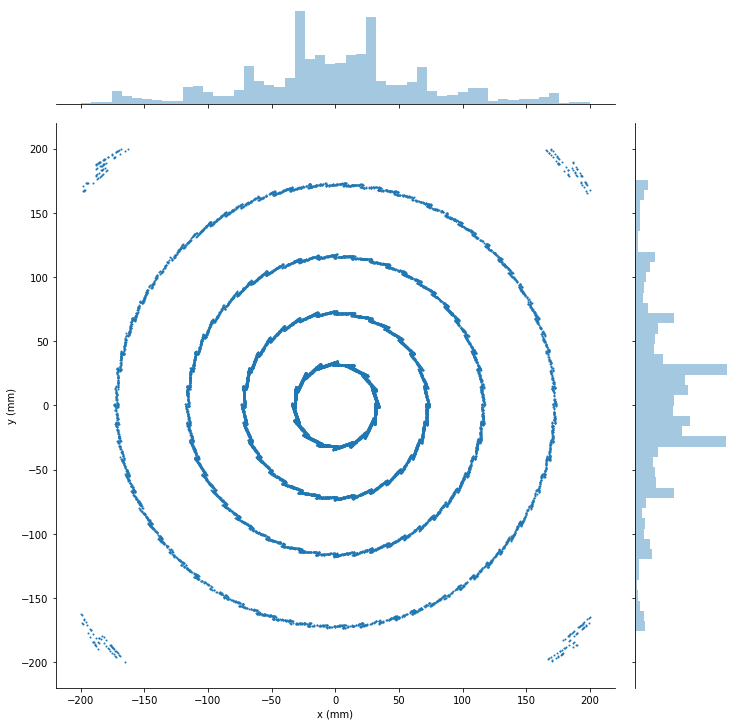

In [12]:
nocap = hits[hits.z.abs()<200]
radialview = sns.jointplot( *(nocap[(nocap.x.abs()<200) & (nocap.y.abs()<200)].loc[:, ["x", "y"]].values.T), height=10, s=1)
radialview.set_axis_labels('x (mm)', 'y (mm)')
plt.show()

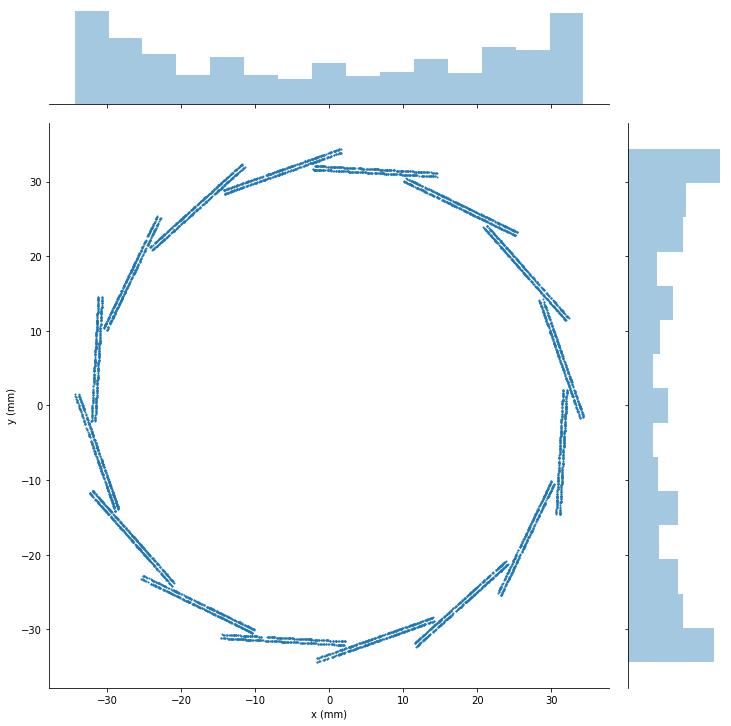

In [13]:
radialview = sns.jointplot( *(nocap[(nocap.x.abs()<50) & (nocap.y.abs()<50)].loc[:, ["x", "y"]].values.T), height=10, s=1)
radialview.set_axis_labels('x (mm)', 'y (mm)')
plt.show()

In [14]:
volumes = hits.volume_id.unique()

Let's plot each detector volume as a different color:

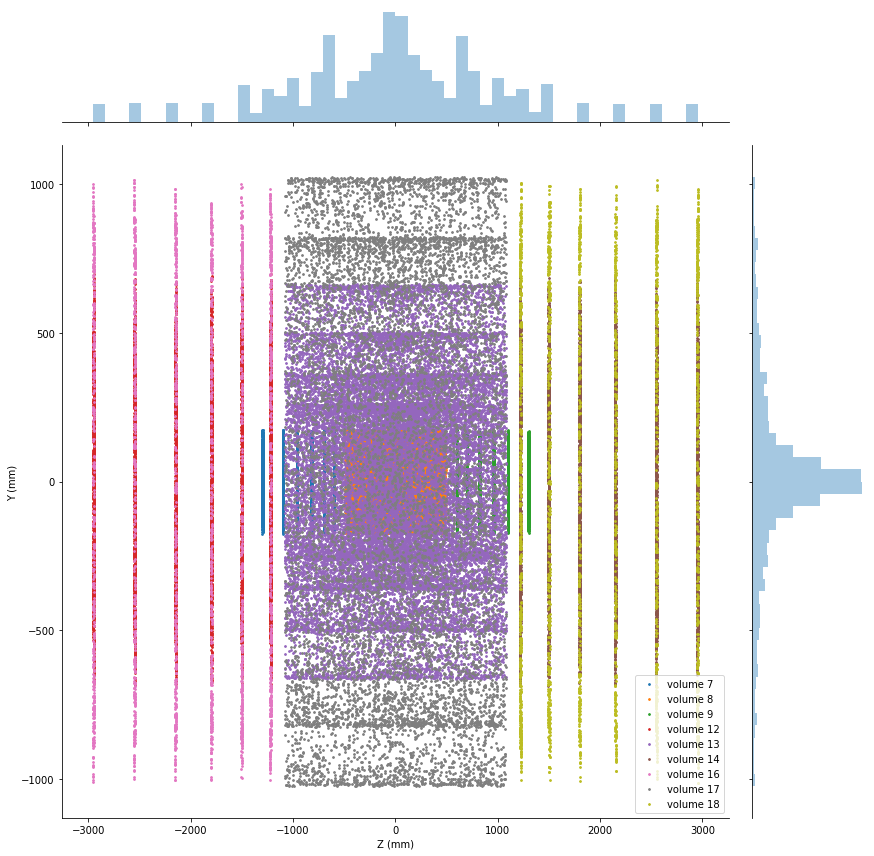

In [16]:
g = sns.jointplot(hits.z, hits.y, s=1, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

We can also plot in 3D

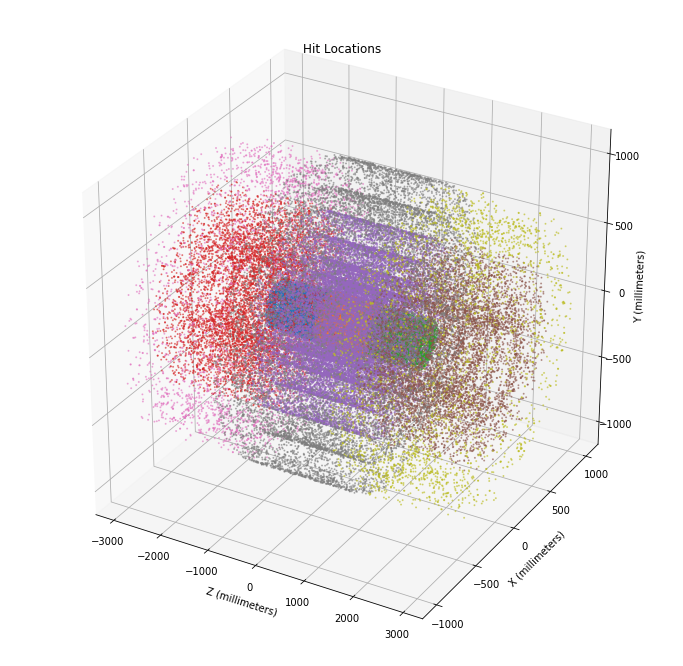

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

Let's pick fewer hits from the event in order to reduce noise

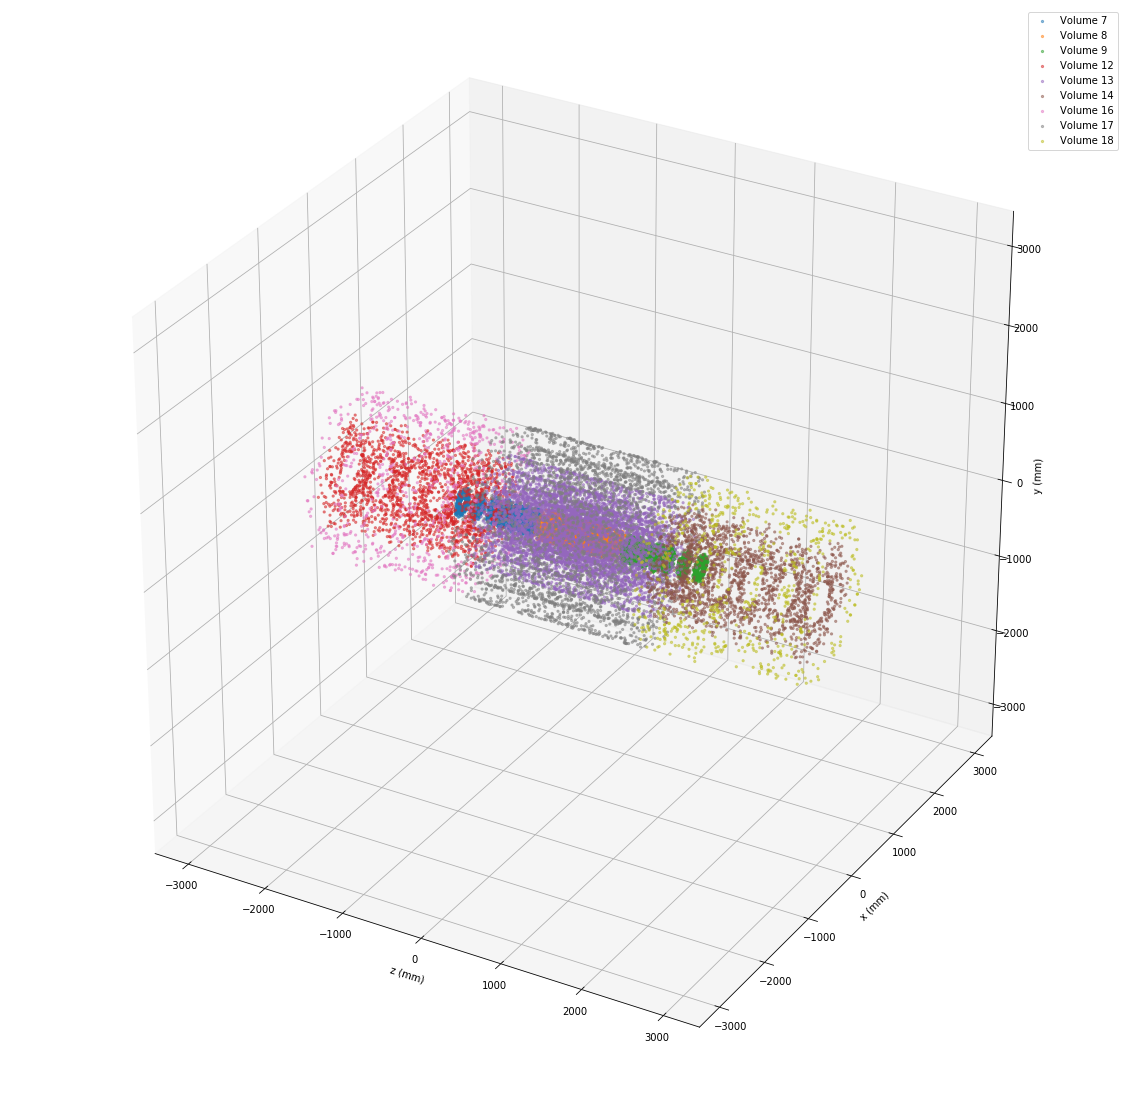

In [18]:
sample = hits.sample(30000)
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
for volume in volumes:
    v = sample[sample.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=5, label='Volume '+str(volume), alpha=0.5)
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.legend()
# These two added to widen the 3D space
ax.scatter(3000,3000,3000, s=0)
ax.scatter(-3000,-3000,-3000, s=0)
plt.show()

In [20]:
layers = hits.layer_id.unique()

Each detector volume is split into layers. Let's look at how layers are organized:

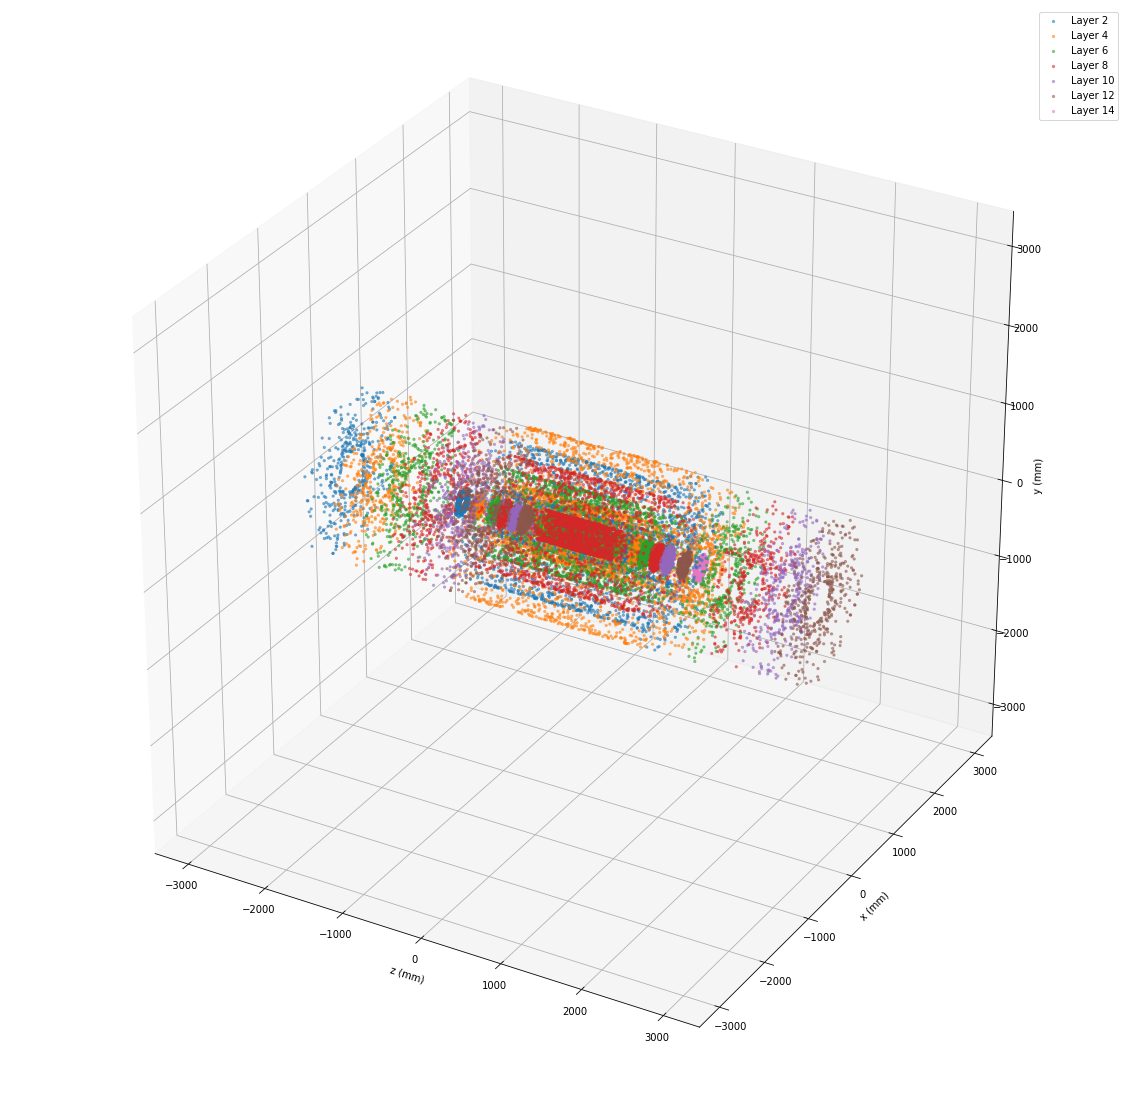

In [21]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
for layer in layers:
    l = sample[sample.layer_id == layer]
    ax.scatter(l.z, l.x, l.y, s=5, label='Layer '+str(layer), alpha=0.5)
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.legend()
# These two added to widen the 3D space
ax.scatter(3000,3000,3000, s=0)
ax.scatter(-3000,-3000,-3000, s=0)
plt.show()

Finally, since we are `particle` physicists, let's look at few tracks. We pick few longest ones here:

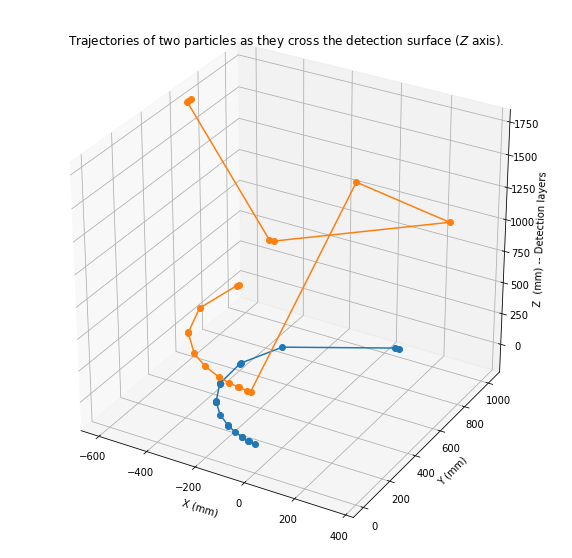

In [22]:
# Get particle id with max number of hits in this event
particle = particles.loc[particles.nhits == particles.nhits.max()].iloc[0]
particle2 = particles.loc[particles.nhits == particles.nhits.max()].iloc[1]

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface = truth[truth.particle_id == particle.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj = (p_traj_surface
          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj.tx,
    ys=p_traj.ty,
    zs=p_traj.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()